# Preprocessing

Now before getting into scientific data analysis, we need **preprocessing**. In IRAF, this was done mainly using `IMCOMBINE` and `IMARITH`. 

Similarly, we can do it using an [Astropy Affiliated package `ccdproc`](http://ccdproc.readthedocs.io/en/stable/index.html), or you can make your own module. The name of the package `ccdproc` roots in the package `CCDPROC` of IRAF. `ccdproc` of astropy is basically aimed to deal with all (and even more) tasks that can be done using `CCDPROC` in IRAF.

As we cannot believe all the packages to work correctly all the time, even this `ccdproc`, I generally recommend to make your own package if you want to do advanced works and rely on as small number of packages as possible (e.g., only numpy, scipy, and astropy core packages).

I will demonstrate preprocessing using `spyder` IDE and `ccdproc` package. I also will not use `subprocess` or `os` modules of Python, because "interactive" manipulation will be more familiar to people who are used to IRAF. If you are familiar with such modules and want to make one single program which does all the preprocessing at once automatically, you can go ahead! I should encourage such trial.

The packages or modules used in this tutorial are

* `ccdproc.CCDData`: If you open fits file using "`astropy.io.fits`", it will contain header and data, i.e., in an HDUList format. Although this gives much freedom, what we need are only very general data from the HDU: data (pixel values) and unit (ADU). `CCDData` is a class of such thing used in `ccdproc`, and it automatically imports only such *core information* from fits files.
* `ccdproc.combine`: Does similar job as `IMCOMBINE` of IRAF.
* `ccdproc.ccd_process`: Mainly used when you want to do all preprocessing with one single function. 

`ccd_process` will be the most frequently used one. If you give image, dark, and bias frame as inputs, there is only one reason you put them: You want a reduced image with dark and bias subtraction! So actually there is no need to explicitly use bias, dark, and flat treating functions one by one. Once bias is specified for `ccd_process`, it will understand you want to subtract bias; once flat is provided, it will do flat fielding. 


-----

## 1. Shell and Python Scripting

Using spyder, you can use Python for scripting AND LINUX commands. This is because spyder uses IPython as the default console. You can do the same thing using IPython on terminal, but IPython itself is generally not good for scripting, so I generally recommend spyder. 

A good point of using spyder as a terminal is that you can easily move from IRAF to Python, especially if you are too familiar with LINUX.

For instance, say you have images:

    0001.fits    0001b.fits    0001d.fits    0001f.fits
    ....
    0010.fits    0010b.fits    0010d.fits    0010f.fits

where '`b`', '`d`', and '`f`' mean bias, dark, and flat images, respectively. 

On spyder, you can change the Editor and Console windows by hitting "`ctrl+shift+e`" and "`ctrl+shift+i`". You don't have to turn the terminal on via "`ctrl+alt+t`", but just hit "`ctrl+shift+i`" and type like this:

```ipython
In [1]: mkdir bias
In [2]: mv *b.fits bias/
In [3]: cd bias/
In [4]: ls *.fits > bias.list
In [5]: cd ..

In [6]: mkdir dark
In [7]: mv *d.fits dark/
In [8]: cd dark/
In [9]: ls *.fits > dark.list
In [10]: cd ..

In [11]: mkdir flat
In [12]: mv *f.fits flat/
In [13]: cd flat/
In [14]: ls *.fits > flat.list
In [15]: cd ..

In [16]: mkdir object
In [17]: mv *.fits object/
In [18]: cd object/
In [19]: ls *.fits > object.list
In [20]: cat object.list
    0001.fits
    ....
    0010.fits
# You can do "cat bias.list" to see the contents in "bias.list"
# See the figure included below.
```
        
Then you have a file '`bias.list`' in the directory '`bias`', with all the 10 bias images, etc. A part of an example:

<img src='images/spyder_01.png' width=300>


* **TIP**: You now may know, but there are many useful shortcuts in spyder:
 * `F9`: run the current line (identical to copy the line, paste it on console, and hit enter)
 * Using "`#%%`": making a "cell". Spyder will automatically highlight the cell you are in. If you hit `ctrl+enter`,  all the lines in the current cell will be run (same as drag lines and hit `F9`) while the cursor remains the position. If you hit `shift+enter`, the cursor will evolve to the next cell so that you can run the next cell again by hitting `shift+enter`.
 * `ctrl+1`: Comment the lines you selected. I changed it to `ctrl+/`, which is more widely used such as in `Atom`.
 * `ctrl+4`: Make a comment box. Try it!
 
-----

## 2. Image Combine

You now must be familiar with the concept of image combine and the necessasity of it. 

I will open the `bias.list` file using `NumPy` and median combine the bias images using `ccdproc`:

In [ ]:
from ccdproc import combine
import numpy as np

filelist = np.loadtxt('bias.list', dtype=bytes).astype(str)

bias = combine(filelist.tolist(),       # ccdproc does not accept numpy.ndarray, but only python list.
               output_file='bias.fits', # I want to save the combined image
               method='median',         # default is average so I specified median.
               unit='adu')              # unit is required: it's ADU in our case.

At each line, I put comments. That's it! 
You succeeded in making a master bias as you did in IRAF by 
    
    imcombine *b.fits bias.fits combine='median'

One thing different from IRAF is that you cannot use command like "`*.fits`".

Of course there are more options like rejection, etc. See the [manual](http://ccdproc.readthedocs.io/en/stable/api/ccdproc.combine.html#ccdproc.combine).

-----

## 3. Dealing with Dark Current

> Although dark current is negligible in many modern optical instruments (only few electrons per pixel per 1 minute), I put this section for educational purpose.

> + The observation data you obtained from our observation session are all **dark-subtracted**! See the header of object files.

Since dark current is linear function of time (since dark noise is Poisson process), we must make dark image as a function of time. If the dark image for exposure time `t` seconds is `dark(t)`, what we do is like this:

    dark(1) = (dark(t) - bias)/t

Then if the object image has exposure time of `t'`, we multiply `dark(1)` by `t'` and use it as "master dark". Because of this, we need to save the exposure time with dark images.

Go to a directory where dark images are in (e.g., `cd ../dark`). 

I want to do:
* median combine all dark frames, save it as "dark0.fits"
* subtract master bias
* 3-sigma clip with 10 iterations 
 * IRAF does 3-sigma with 50 iterations by default.
* set the rejected pixel values as the median value
* save it as "dark.fits"

  

In [ ]:
import numpy as np
from astropy.stats import sigma_clip
from ccdproc import CCDData, ccd_process, combine

# cd ../dark

filelist = np.loadtxt('dark.list', dtype=bytes).astype(str)

dark0 = combine(filelist.tolist(),        # ccdproc does not accept numpy.ndarray, but only python list.
                output_file='dark0.fits', # I want to save the combined image
                method='median',          # default is average so I specified median.
                unit='adu')               # unit is required: it's ADU in our case.

# This dark isn't bias subtracted yet, so let's subtract bias:               

# (1) Open master bias
bias = CCDData.read('../bias/bias.fits', unit='adu')
# `unit='adu'` does not necessarily be set if you have header keyword for it.

# (2) Subtract bias:
dark = ccd_process(dark0, master_bias=bias) 
# This automatically does "dark-bias"
# You can do it by the function "subtract_bias", or just normal pythonic arithmetic.

# (3) Sigma clip the dark
dark_clip = sigma_clip(dark) 
# by default, astropy.stats.sigma_clip does "3-sigma, 10-iterations" clipping.
# You can tune the parameters by optional keywords (e.g., sigma, iters, ...).
# dark_clip is "numpy masked array". It contains data, mask, and filled_value.
# filled_value is the value which is used to fill the data which are masked (rejected).
# I will change filled_value to be the median value.

# (4) For rejected pixels, insert the median value
dark_clip.fill_value = np.median(dark_clip.data) 
dark.data = dark_clip.filled() # ~.filled() gives the "data array using filled_value"

# (5) Save
dark.write('dark.fits')

You may see the following `INFO` message when loading the bias image:

    INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [ccdproc.ccddata]

This is because you are assigning the unit `'adu'` to the FITS file even though the FITS has its own unit (the header keyword `UNIT`). Of course that unit should be ADU, since we have saved the CCDData object in ADU unit.

As you can see from the dark image, the value is very small. It's only about less than 10 counts (ADU) per 30 seconds, which means less than 1 ADU per second. In better telescopes, dark is extremely small, so you can safely ignore dark (i.e., assume dark current = 0 adu).

-----


## 3. Dealing with Flat

Now we have to subtract bias and dark from flat. Go to the flat directory (e.g., "`cd ../flat/`). I want to do the followings similar to dark:

* median combine all flat frames, save it as "flat0.fits"
* subtract master bias and dark (dark should be scaled)
* save it as "flat.fits"

Because flat has spatial variation, I cannot replace the rejected pixel values with median of all pixels! It's customary to set a lower limit of pixel value (`min_value`) and replace pixel values smaller than this value: Change pixels smaller than `min_value` to `min_value`. This will be done later, but of course you can do it at this stage if you wish to.

As I said in the previous section, dark frame should be "scaled" so that it gives correct (estimated) dark current value for given exposure time: `dark(t)/t * t'`. This is automatically done if you set the option "`dark_scale`" from the fucntion `ccd_process`.


In [ ]:
import numpy as np
from ccdproc import CCDData, ccd_process, combine
import astropy.units as u

# cd ../flat

filelist = np.loadtxt('flat.list', dtype=bytes).astype(str)

flat0 = combine(filelist.tolist(),        # ccdproc does not accept numpy.ndarray, but only python list.
                output_file='flat0.fits', # I want to save the combined image
                method='median',          # default is average so I specified median.
                unit='adu')               # unit is required: it's ADU in our case.

#%%
# (1) Open master bias and dark
bias = CCDData.read('../bias/bias.fits', unit='adu')
dark = CCDData.read('../dark/dark.fits', unit='adu')

# (2) Subtract bias and dark
flat = ccd_process(flat0,                  # The input image (median combined flat)
                   master_bias=bias,       # Master bias
                   dark_frame=dark,        # dark
                   dark_exposure=30 * u.s, # exposure time of dark
                   data_exposure=1  * u.s, # exposure time of input image (flat)
                   dark_scale=True)        # whether to scale dark frame
# (3) Save
flat.write('flat.fits')


But sometimes you may not want to find the exposure times of dark and data frames, because they are all written in the header keyword. Usually people put the exposure time to the header keyword `EXPTIME` (or sometimes `EXPOSURE`). The unit may differ from FITS to FITS, so you should know the unit of it. In our case it is seconds.

So the following excerption can do the same process as above, without specifying the exposure times explicitly. The function automatically touches and reads the header information from dark and image, and it extracts the exposure time information:

``` python
flat = ccd_process(flat0,                  
                   master_bias=bias,       
                   dark_frame=dark,        
                   exposure_key='exptime', # the header keyword for exposure time
                   exposure_unit=u.s,      # the unit of exposure time
                   dark_scale=True)        
```

This is much more general and useful, so preferred.

-----

## 4. Reducing Object Images

If you have made master bias, dark, and master flat (median combined flat - (bias + dark)), what you can do is simply (object - (bias + dark)) / (master flat). You may usually ignore dark current.

But there is second option: ALL AT ONCE using one single function. This is because the preprocessing is straightforward process. If you provide master bias, median combined flat (the file `flat0.fits` in the previous section), dark frame, and object image, the flowchart is clear: make master flat, scale the dark image, and preprocess the image. I will show you how to use this second option:


In [ ]:
import numpy as np
from ccdproc import CCDData, ccd_process, combine
import astropy.units as u
#%%

filelist = np.loadtxt('object.list', dtype=bytes).astype(str)

#%%
# (1) Open master bias, dark, and flat
bias  = CCDData.read('../bias/bias.fits', unit='adu')
dark  = CCDData.read('../dark/dark.fits', unit='adu')
flat0 = CCDData.read('../flat/flat0.fits', unit='adu') # Bias NOT subtracted

# (2) Reduce each object image separately.
#     Then save it with prefix 'p_' which means "preprocessed"
for objname in filelist:
    obj = CCDData.read(objname, unit='adu')
    reduced = ccd_process(obj,                    # The input image
                          master_bias=bias,       # Master bias
                          dark_frame=dark,        # dark
                          master_flat=flat0,      # non-calibrated flat
                          min_value=30000,        # flat.min() should be 30000
                          exposure_key='exptime', # exposure time keyword
                          exposure_unit=u.s,      # exposure time unit
                          dark_scale=True)        # whether to scale dark frame
    reduced.write('p_'+objname)


For comparison, let me show you how the flat fielding changed the result. You can clearly see that the dust doughnut patterns are gone in the pre-processed image.

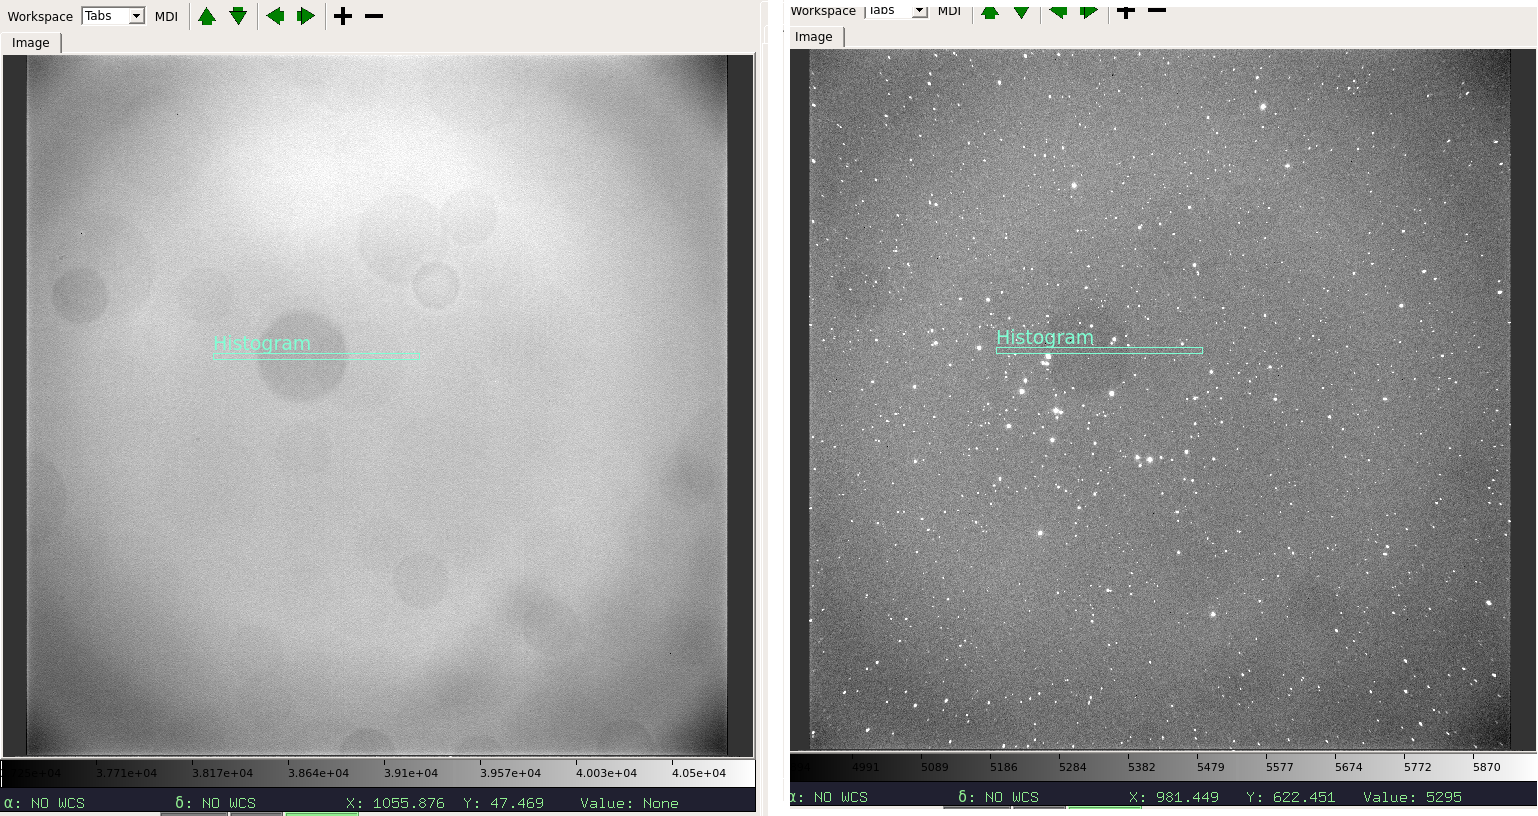

In [27]:
from IPython.display import Image
Image('images/preproc_flat0.png', width=900)

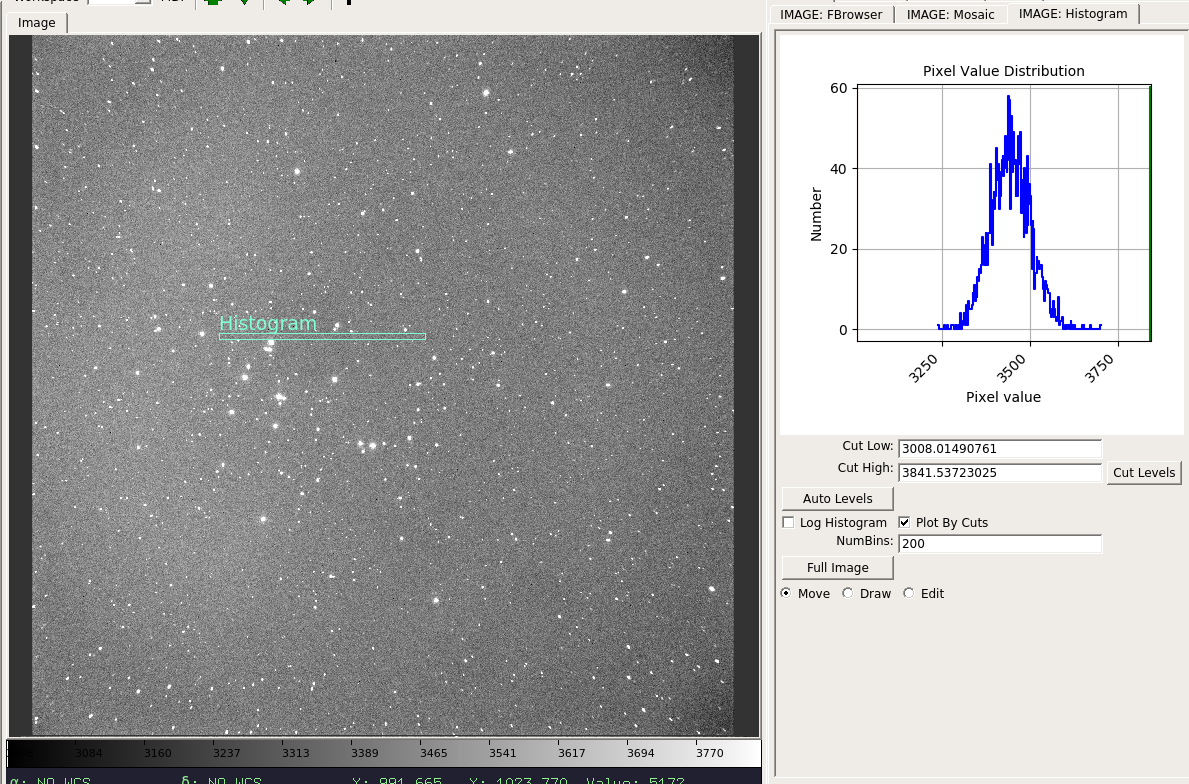

In [28]:
Image('images/preproc_objreduc.png', width=700)

* **Question**: Why do you think the pixel values (see the bottom color-bar of each image) is changed by ~ 1000 ADU order after pre-processing?
* **Question**: The pixel values in the final pre-processed image should also be in ADU unit. Each pixel value of the raw image is integer. Why do you think the processed image has non-integer, but a very peculiar rational numbered pixel values?

* **TIP**: If you remember the result from IRAF, you may wonder why the preprocessed pixel values are this large. It is because **ccd_process does "nomalization" to flat image by defauly, by dividing the flat image by its average value** (before cropping pixels with pixel value < `min_value`).

* **Question**: What will happen if you set `min_value=40000`?



-----

## 5. Implementing WCS

In this image, the WCS information is not implemented to the header. You can upload the image file to [Astrometry.net](http://nova.astrometry.net/upload), and the website will figure out where the sky region is, and implements the WCS information. Astrometry finds the sources by SExtractor, and checks the configuration of stars. Since the sky region can be uniquely determined if enough number of sources are detected, it automatically implements WCS. 

If the WCS matching is done successfully, you will see the following page. Click on "Go to results page" and save the WCS-implemented fits file by clicking on "new-image.fits".

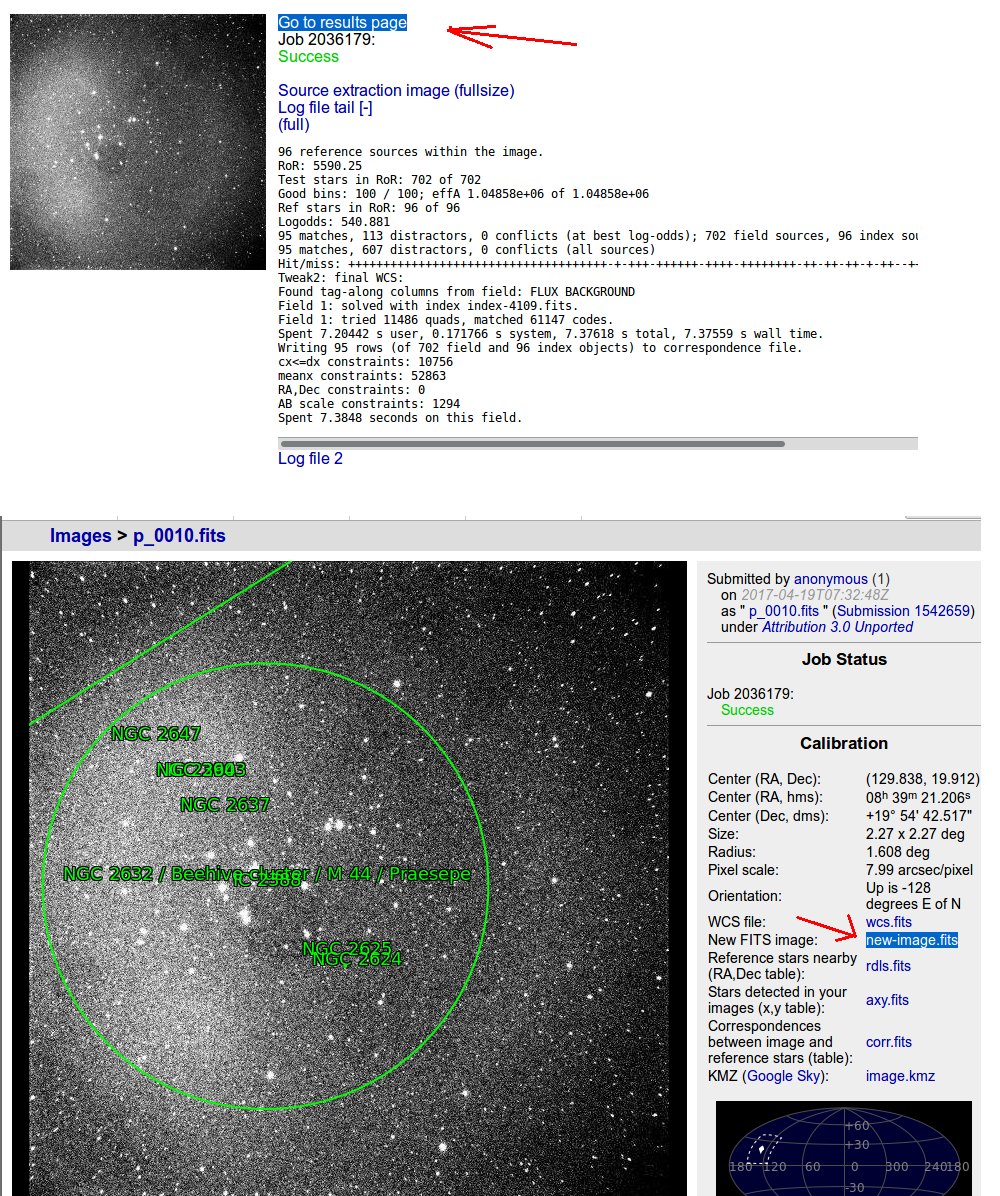

In [24]:
Image('images/preproc_astrometry.png', width=600)